# BIG CHALLENGE/DILEMMA

Twee opties:
1. We lezen de .net-bestanden (1 per sliding window) los in en runnen voor elk bestand een losse *graph partitioning* analyse
2. We voegen het eerst samen tot één graaf en doen slechts één analyse

voordelen 1:
- geen 'ketenen': het kan niet gebeuren dat een gebeurtenis uiteindelijk meerdere weken omvat, omdat er telkens weer een bruggetje is wat een cluster aansluit op het volgende

nadelen 1:
- een artikel kan bij meerdere events horen (laatste dag van een bestand = middenste dag van het volgende bestand); deze overlap is niet gewenst


# Detecting and analyzing news events

Damian Trilling and Marieke van Hoof


This Notebook contains the analysis of the similarity files created with the INCA-functions to calculate cosine and soft-cosine similarities.

In [1]:
from glob import glob
import json
from tqdm import tqdm
import leidenalg
import igraph as ig
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Load/specify datasets

We need to load three datasets:

1. Nodes and edges for the softcosine-dataset
2. As a baseline for comparisons: nodes and edges for the traditional cosine dataset
3. The articles themselves (titles, texts, ...) to join with the first two datasets

In [2]:
softcosinefiles = glob('../../data/intermediate/softcosine/*.net')
cosinefiles = glob('../../data/intermediate/cosine/*.net')

print('There are {} softcosine and {} cosine files.'.format(len(softcosinefiles), len(cosinefiles)))

There are 149 softcosine and 149 cosine files.


In [3]:
# There are essentially two ways of going about combining all our files
# Either we merge them first and create ONE graph that we partition later,
# or we partition each file's graph seperately.
# The theoretical implication is that in the first scenario, the three-day
# moving window can be stretched (as something on the last day of a window
# can also be similar to sth in the 'new' window), in the latter scenario,
# that's not possible. 
# Empirical tests show that this stretching can lead to a drift over time,
# with large partitions that extend to multiple events. We therefore do 
# *not* do this in the final paper:

def merge_pajekfiles(files, outputfile):
    G = nx.Graph()
    for f in tqdm(files):
        H = nx.read_pajek(f)
        for node in H:         # remove all node properties, such as misleading/non-unique ids
            del H.node[node]['id']
            del H.node[node]['x']
            del H.node[node]['y']
            del H.node[node]['shape']
        G.update(H)
    print('{} nodes and {} edges'.format(len (G.nodes), len(G.edges)))
    print('Removing self loops...')
    G.remove_edges_from(list(G.selfloop_edges()))
    print('{} nodes and {} edges'.format(len (G.nodes), len(G.edges)))
    nx.write_pajek(G, outputfile)
    print('All written to {}'.format(outputfile))
    return G
# Gnxsoft = merge_pajekfiles(softcosinefiles, '../../data/intermediate/softcosine_merged.net')
# Gnxcos = merge_pajekfiles(cosinefiles, '../../data/intermediate/cosine_merged.net')
# Gsoft = ig.read('../../data/intermediate/softcosine_merged.net', format='pajek')
# Gcos = ig.read('../../data/intermediate/cosine_merged.net', format='pajek')


In [4]:
with open('../../data/raw-private/articles/articles_as_json-lines.json', mode='r') as f:
    articles = pd.DataFrame((json.loads(l) for l in f))
print(articles.keys())
print('{} articles in total'.format(len(articles)))

Index(['_id', 'byline', 'category', 'doctype', 'feedurl', 'images',
       'paywall_na', 'publication_date', 'softcosine_processed', 'teaser',
       'teaser_rss', 'text', 'title', 'title_rss', 'url'],
      dtype='object')
45609 articles in total


## Define functions
Here, we define functions to transform the files to a graph, partition the graph, analyze it, etc.

In [5]:
def partition_graph(G, minedgeweight):
    '''takes an igraph, prunes it and particions it. returns a list of partitions '''
    G.es.select(weight_le=minedgeweight).delete()
    part = leidenalg.find_partition(G, leidenalg.ModularityVertexPartition)
    # print(part.summary())
    partitions = []
    for subgraph in part.subgraphs():
         partitions.append([node['id'] for node in subgraph.vs])
    return partitions

In [6]:
# this may be buggy. I believe we need to FIRST merge the graphs, then do the partitioing,
# because otherwise the same article can end up in multiple events

def analyze_files_BAD(files, minedgeweight=.2):
    '''Reads a list of graph files, passes them to partition_graph(), and concatenats the results'''
    G = ig.Graph()
    results = []
    for f in tqdm(files):
        Gi = ig.read(f, format='pajek')
        try:
            results.extend(partition_graph(Gi, minedgeweight))
        except Exception as e:
            print('Error while trying to process edge weights in file {}'.format(f))
            print(e)
    return results

In [ ]:
Gi= ig.read(softcosinefiles[0], format='pajek')
Gi.vs.attribute_names()

In [ ]:
Gi.vs()[0]

In [ ]:
def analyze_files(files, minedgeweight=.2):
    '''Reads a list of graph files, passes them to partition_graph(), and concatenats the results'''
    G = ig.Graph()
    results = []
    for f in tqdm(files):
        Gi = ig.read(f, format='pajek')
        try:
            results.extend(partition_graph(Gi, minedgeweight))
        except Exception as e:
            print('Error while trying to process edge weights in file {}'.format(f))
            print(e)
    return results

In [7]:
def show_descriptives(results):
    '''takes a list of lists (articles per event), plots a histogram and prints descriptives'''
    articles_per_event = [len(x) for x in results]
    fig = plt.figure(figsize=(10,5))
    plt.hist(articles_per_event, bins = max(articles_per_event), log=True)
    plt.show()
    print(pd.Series(articles_per_event).describe())

## Conduct clustering

We now conduct the clustering. We use a grid in which we vary the similarity calculation (cosine vs softcosine) and the minimum edgeweight threshold (.2, .3, .4)

In [ ]:

grid = [('cos', Gcos, .2),
        ('cos', Gcos, .3),
        ('cos', Gcos, .4),
        ('softcos', Gsoft, .2),
        ('softcos', Gsoft, .3),
        ('softcos', Gsoft, .4)]

gridresults = [{'similarity':similarity, 'minedgeweight': minedgeweight, 'results': partition_graph(G, minedgeweight)} 
              for similarity, G, minedgeweight in grid]



In [8]:
# alternative
grid = [('cos', cosinefiles, .2),
        ('cos', cosinefiles, .3),
        ('cos', cosinefiles, .4),
        ('softcos', softcosinefiles, .2),
        ('softcos', softcosinefiles, .3),
        ('softcos', softcosinefiles, .4)]

gridresults = [{'similarity':similarity, 'minedgeweight': minedgeweight, 'results': analyze_files_BAD(files, minedgeweight)} 
              for similarity, files, minedgeweight in grid]



100%|██████████| 149/149 [00:04<00:00, 36.46it/s]


********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.2

********************************************************************************


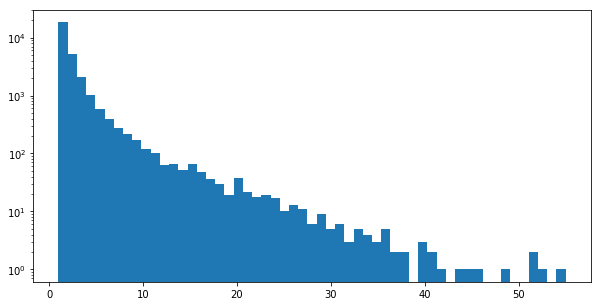

count    29059.00000
mean         2.16642
std          3.06887
min          1.00000
25%          1.00000
50%          1.00000
75%          2.00000
max         55.00000
dtype: float64




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.3

********************************************************************************


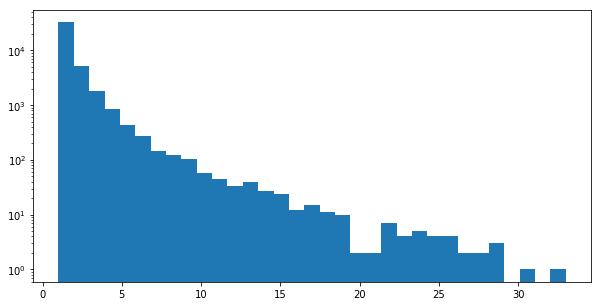

count    41720.000000
mean         1.508965
std          1.573367
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         33.000000
dtype: float64




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.4

********************************************************************************


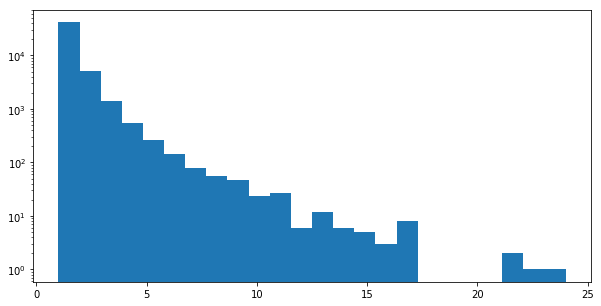

count    49311.000000
mean         1.276673
std          0.923085
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         24.000000
dtype: float64




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.2

********************************************************************************


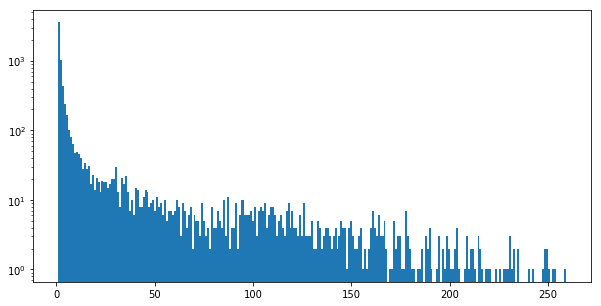

count    7197.000000
mean       15.538141
std        37.508137
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       259.000000
dtype: float64




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.3

********************************************************************************


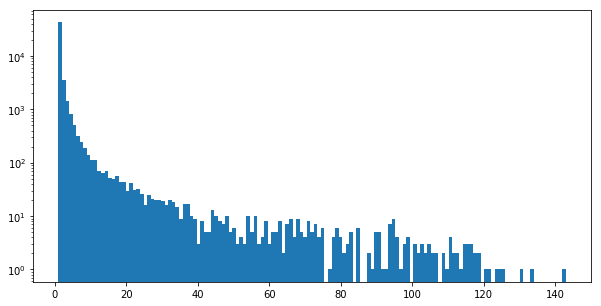

count    51452.000000
mean         2.173443
std          6.713488
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        143.000000
dtype: float64




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.4

********************************************************************************


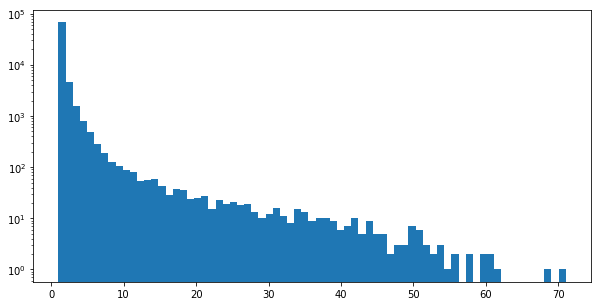

count    76911.000000
mean         1.453992
std          2.653041
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         71.000000
dtype: float64






In [9]:
for r in gridresults:
    print("*"*80)
    print('Similarity metric: {}\n Minimum edgeweight: {}\n'.format(r['similarity'], r['minedgeweight']))
    print("*"*80)
    show_descriptives(r['results'])
    print('\n\n\n')

In [10]:
for r in gridresults:
    l = r['results']
    flattened = [item for sublist in l for item in sublist]

    print('Found {} articles, out of which {} are unique articles'.format(len(flattened), len(set(flattened))))
print('(hint: all articles should be unique)')

Found 62954 articles, out of which 45213 are unique articles
Found 62954 articles, out of which 45213 are unique articles
Found 62954 articles, out of which 45213 are unique articles
Found 111828 articles, out of which 45608 are unique articles
Found 111828 articles, out of which 45608 are unique articles
Found 111828 articles, out of which 45608 are unique articles
(hint: all articles should be unique)


In [ ]:
gridresults[5]['results'][3]

In [ ]:
for i in range(10):
    print(Gcos.vs()[i])

## Evaluation of the results

check how much sense it makes etc

In [14]:
df = pd.DataFrame(gridresults[3]['results'])
df

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,https://www.ad.nl/binnenland/doodgeschoten-hum...,https://www.ad.nl/rotterdam/doodsbedreigingen-...,https://www.ad.nl/binnenland/papa-chris-apetro...,https://www.ad.nl/schaatsen/normaal-is-mijn-mo...,https://www.nu.nl/-/5680244/,https://www.ad.nl/binnenland/humeyra-werd-stee...,https://www.ad.nl/schaatsen/normaal-is-mijn-mo...,https://www.ad.nl/binnenland/bekir-e-loofde-ze...,https://www.ad.nl/reizen/sneeuwbom-in-skigebie...,https://www.ad.nl/binnenland/humeyra-werd-stee...,...,None,None,None,None,None,None,None,None,None,None
1,https://www.ad.nl/binnenland/chauffeur-56-die-...,https://www.nu.nl/-/5680214/,https://www.nu.nl/-/5680385/,https://www.ad.nl/buitenland/gewonden-bij-zwar...,https://www.nu.nl/-/5680484/,https://www.ad.nl/binnenland/trucker-reed-door...,https://www.ad.nl/buitenland/gele-hesjes-nu-oo...,https://www.ad.nl/binnenland/tilburger-reed-do...,https://www.nu.nl/-/5679491/,https://www.nu.nl/-/5679665/,...,None,None,None,None,None,None,None,None,None,None
2,https://www.nu.nl/-/5680079/,https://www.nu.nl/-/5681249/,https://www.ad.nl/schaatsen/gedachten-bij-ek-s...,https://www.nu.nl/-/5680409/,https://www.ad.nl/schaatsen/afstandswinst-is-m...,https://www.ad.nl/schaatsen/schulting-valt-van...,https://www.ad.nl/schaatsen/schulting-doet-t-v...,https://www.nu.nl/-/5680088/,https://www.ad.nl/schaatsen/oppermachtige-de-j...,https://www.ad.nl/schaatsen/kai-verbij-soevere...,...,None,None,None,None,None,None,None,None,None,None
3,https://www.ad.nl/nederlands-voetbal/ten-hag-p...,https://www.ad.nl/buitenlands-voetbal/alaves-k...,https://www.ad.nl/buitenlands-voetbal/sevilla-...,https://www.ad.nl/nederlands-voetbal/ajax-slui...,https://www.ad.nl/nederlands-voetbal/ten-hag-v...,https://www.nu.nl/-/5679707/,https://www.nu.nl/-/5681177/,https://www.ad.nl/transfer-talk/ac-milan-gaat-...,https://www.ad.nl/transfer-talk/danjuma-gevlei...,https://www.ad.nl/buitenlands-voetbal/salah-he...,...,None,None,None,None,None,None,None,None,None,None
4,c8a7cd9,https://www.nu.nl/-/5669321/,https://www.nu.nl/-/5679479/,https://www.ad.nl/buitenland/president-trump-w...,https://www.nu.nl/-/5680181/,038f4d7,https://www.ad.nl/buitenland/zoon-van-mexicaan...,https://www.nu.nl/-/5680658/,https://www.nu.nl/-/5680742/,https://www.ad.nl/buitenland/trump-hield-detai...,...,None,None,None,None,None,None,None,None,None,None
5,https://www.ad.nl/binnenland/amsterdam-legde-p...,https://www.nu.nl/-/5679476/,https://www.ad.nl/buitenland/extreem-groot-law...,https://www.ad.nl/binnenland/eerste-schip-ter-...,https://www.nu.nl/-/5680292/,https://www.ad.nl/binnenland/wadden-zijn-dit-w...,https://www.ad.nl/show/agenten-doorzoeken-woni...,https://www.nu.nl/-/5679938/,https://www.nu.nl/-/5680883/,https://www.ad.nl/buitenland/sneeuwchaos-leger...,...,None,None,None,None,None,None,None,None,None,None
6,https://www.ad.nl/wielrennen/kwik-boven-de-40-...,https://www.nu.nl/-/5680856/,https://www.nu.nl/-/5680058/,https://www.ad.nl/andere-sporten/karginov-uit-...,https://www.ad.nl/andere-sporten/ton-van-genug...,https://www.ad.nl/wielrennen/ewan-boekt-in-ade...,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7,https://www.ad.nl/binnenland/nuon-verkoper-ik-...,https://www.nu.nl/-/5680430/,https://www.ad.nl/binnenland/nuon-verkopers-mi...,https://www.ad.nl/economie/al-20-000-krabbels-...,https://www.nu.nl/-/5679818/,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
8,https://www.ad.nl/koken-en-eten/falafelsalade-...,https://www.ad.nl/koken-en-eten/met-deze-recep...,https://www.ad.nl/koken-en-eten/deze-drie-taar...,https://www.ad.nl/koken-en-eten/deze-drie-taar...,https://www.ad.nl/koken-en-eten/recept-van-de-...,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
9,https://www.nu.nl/-/5679716/,https://www.nu.nl/-/5680991/,https://www.nu.nl/-/5679740/,https://www.nu.nl/-/5680715/,None,None,None,None,None,None,...,None,None,None,Non

In [15]:
df['numberofarticles'] = df.apply(lambda x: sum(x.notna()), axis=1)

In [16]:
df.query('numberofarticles>100')

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,numberofarticles
65,https://www.ad.nl/buitenland/meisje-springt-ui...,241a184,212ae13,ac2012d,https://www.ad.nl/binnenland/agenten-woest-na-...,https://www.ad.nl/binnenland/bang-voor-beschad...,https://www.ad.nl/binnenland/jorien-en-jasper-...,https://www.nu.nl/-/5739021/,https://www.ad.nl/ad-werkt/mijn-salaris-is-bij...,https://www.ad.nl/utrecht/moordenaar-sybine-ja...,...,None,None,None,None,None,None,None,None,None,188
66,https://www.ad.nl/buitenland/nigeriaanse-weduw...,https://www.ad.nl/buitenland/nigeriaanse-weduw...,https://www.nu.nl/-/5737542/,https://www.nu.nl/-/5738328/,https://www.ad.nl/ad-werkt/frauderende-ambtena...,86b73c7,https://www.ad.nl/binnenland/om-eist-12-jaar-i...,f2502a0,https://www.nu.nl/-/5739393/,https://www.ad.nl/buitenland/politie-vs-pakt-m...,...,None,None,None,None,None,None,None,None,None,104
67,https://www.ad.nl/buitenlands-voetbal/engelse-...,https://www.nu.nl/-/5739372/,https://www.ad.nl/buitenlands-voetbal/cardiff-...,https://www.ad.nl/buitenlands-voetbal/gordon-b...,https://www.ad.nl/buitenlands-voetbal/oud-spel...,https://www.nu.nl/-/5739534/,https://www.nu.nl/-/5738043/,https://www.ad.nl/offside/asensio-zegt-hallo-a...,https://www.ad.nl/buitenlands-voetbal/pele-gor...,https://www.ad.nl/buitenlands-voetbal/lampard-...,...,None,None,None,None,None,None,None,None,None,101
120,ea10030,https://www.ad.nl/ad-werkt/als-je-niet-in-team...,2955098,https://www.nu.nl/-/5661785/,https://www.ad.nl/buitenland/het-water-komt-to...,https://www.ad.nl/show/gestopte-dj-hardwell-ve...,https://www.ad.nl/ad-werkt/in-deze-functie-ont...,https://www.ad.nl/binnenland/appelgroen-huis-v...,https://www.ad.nl/buitenland/nederlands-stel-b...,https://www.ad.nl/den-haag/burgemeester-krikke...,...,None,None,None,None,None,None,None,None,None,209
121,https://www.ad.nl/buitenland/pedofiel-komt-vri...,https://www.ad.nl/buitenland/chinese-jack-the-...,https://www.nu.nl/-/5662910/,https://www.nu.nl/-/5661827/,https://www.ad.nl/buitenland/steeds-meer-vraag...,https://www.ad.nl/rotterdam/advocaat-opgepakte...,https://www.nu.nl/-/5663087/,https://www.nu.nl/-/5662637/,https://www.nu.nl/-/5662715/,https://www.ad.nl/rotterdam/schutter-die-rappe...,...,None,None,None,None,None,None,None,None,None,174
122,https://www.ad.nl/nederlands-voetbal/feyenoord...,https://www.ad.nl/transfer-talk/anderlecht-kri...,https://www.ad.nl/transfer-talk/karsdorp-terug...,https://www.ad.nl/buitenlands-voetbal/de-moois...,https://www.ad.nl/buitenlands-voetbal/talent-z...,https://www.ad.nl/transfer-talk/fc-emmen-haalt...,https://www.ad.nl/buitenlands-voetbal/son-late...,https://www.ad.nl/transfer-talk/nac-heeft-aust...,https://www.ad.nl/transfer-talk/napoli-wil-loz...,https://www.ad.nl/buitenlands-voetbal/keizer-k...,...,None,None,None,None,None,None,None,None,None,110
166,https://www.nu.nl/-/5891826/,https://www.ad.nl/politiek/kamer-boos-over-bez...,https://www.ad.nl/buitenland/record-aan-co2-in...,https://www.ad.nl/ad-werkt/tekorten-in-technie...,6d16f75,3743a96,cb95ae6,4d33ee9,243c31f,e16f9c5,...,None,None,None,None,None,None,None,None,None,202
167,https://www.nu.nl/-/5890518/,https://www.nu.nl/-/5891553/,229808b,https://www.nu.nl/-/5890962/,https://www.ad.nl/sterren/jennifer-lopez-geeft...,https://www.ad.nl/show/vriend-trijntje-oosterh...,e62e01e,https://www.nu.nl/-/5892162/,https://www.ad.nl/den-haag/jaar-cel-geeist-teg...,https://www.ad.nl/den-haag/acht-maanden-cel-ge...,...,None,None,None,None,None,None,None,None,None,160
168,https://www.nu.nl/-/5891787/,https://www.nu.nl/-/5891619/,https://www.nu.nl/-/5891484/,https://www.nu.nl/-/5891748/,https://www.ad.nl/buitenlands-voetbal/mino-die...,https://www.nu.nl/-/5890890/,https://www.ad.nl/nederlands-voetbal/de-jong-o...,https://www.nu.nl/-/5891535/,https://www.nu.nl/-/5891991/,https://www.nu.nl/-/5890851/,...,None,None,None,None,None,None,None,None,None,104
218,https://www.ad.nl/buitenland/zoon-gaat-door-he...,https://www.nu.nl/-/5768025/,https

In [20]:
articles.query('_id=="{}"'.format('https://www.ad.nl/binnenland/doodgeschoten-humeyra-16-wilde-vluchten-naar-turkije~a8e5014d/'))

,_id,byline,category,doctype,feedurl,images,paywall_na,publication_date,softcosine_processed,teaser,teaser_rss,text,title,title_rss,url
36247,https://www.ad.nl/binnenland/doodgeschoten-hum...,Victor Schildkamp en Sander Sonnemans,Binnenland,ad (www),http://www.ad.nl/rss.xml,[{'url': 'https://images0.persgroep.net/rcs/Zw...,False,2019-01-12T04:00:13,humeyra durfde de maanden vooraf aan de moord ...,NaN,De 16-jarige Humeyra wilde uit angst voor de c...,Humeyra durfde de maanden vooraf aan de moord ...,Doodgeschoten Humeyra (16) wilde vluchten naar...,Doodgeschoten Humeyra (16) wilde vluchten naar...,https://www.ad.nl/binnenland/doodgeschoten-hum...


In [19]:
def results_to_titles(results):
    results_titles = [[articles.query('_id=="{}"'.format(art))['title'].to_list()[0] for art in event] for event in tqdm(results)]
    return(results_titles)


In [23]:
softcosine_results_titles = results_to_titles(gridresults[5]['results'])


  4%|▎         | 2871/76911 [00:20<05:44, 214.87it/s]


  8%|▊         | 5975/76911 [00:40<15:08, 78.10it/s] 


 12%|█▏        | 9470/76911 [01:00<05:44, 196.04it/s]


 17%|█▋        | 12778/76911 [01:21<04:32, 235.18it/s]


 20%|██        | 15738/76911 [01:41<04:33, 223.37it/s]


 24%|██▍       | 18692/76911 [02:01<04:18, 225.25it/s]


 29%|██▊       | 22004/76911 [02:21<03:42, 246.87it/s]


 33%|███▎      | 25314/76911 [02:42<03:55, 219.29it/s]


 37%|███▋      | 28440/76911 [03:03<09:24, 85.93it/s]


 41%|████▏     | 31887/76911 [03:22<03:49, 195.88it/s]


 46%|████▌     | 35436/76911 [03:42<03:10, 217.48it/s]


 51%|█████     | 38940/76911 [04:01<02:28, 256.51it/s]


 55%|█████▍    | 42278/76911 [04:21<02:15, 256.35it/s]


 60%|█████▉    | 45809/76911 [04:40<02:48, 184.92it/s]


 64%|██████▍   | 49254/76911 [05:00<03:01, 151.97it/s]


 69%|██████▊   | 52798/76911 [05:19<01:36, 249.98it/s]


 73%|███████▎  | 56177/76911 [05:39<03:58, 87.09it/s]


 77%|███████▋  | 59479/76911 [05:58<01:09, 250.92it/s]


 81%|████████  | 62273/76911 [06:17<00:58, 250.16it/s]


 85%|████████▌ | 65587/76911 [06:37<00:53, 212.12it/s]


 90%|████████▉ | 68851/76911 [06:57<01:28, 90.69it/s]


 94%|█████████▎| 72019/76911 [07:16<00:21, 228.14it/s]


 98%|█████████▊| 75362/76911 [07:35<00:08, 177.12it/s]


100%|██████████| 76911/76911 [07:45<00:00, 165.18it/s]

In [24]:
df_titles = pd.DataFrame(softcosine_results_titles)

In [25]:
df_titles['numberofarticles'] = df_titles.apply(lambda x: sum(x.notna()), axis=1)

In [26]:
df_titles.query('numberofarticles<=3')[[0,1,2]]

,0,1,2
17,Nicolette Kluijver kondigt scheiding aan,‘Nicolette Kluijver en man knokken ervoor om s...,Nicolette Kluijver en Joost Staudt 'knokken' v...
18,Zoon van Mexicaanse immigrant meldt zich als t...,Tweede presidentskandidaat voor Democraten is ...,Julian Castro meldt zich als tweede presidents...
19,Washington Post: Trump hield details over ontm...,'Trump hield details van gesprek met Poetin ge...,‘Trump hield details over ontmoeting met Poeti...
20,Zeventien doden bij brand in afkickkliniek Ecu...,Achttien doden bij brand in afkickkliniek Ecuador,Zeker achttien doden door brand in afkickklini...
21,Verstappen ziet taakstraf als ‘interessante en...,Verstappen ervaart uitvoeren van taakstraf als...,Frijns eindigt als tweede bij tweede Formule E...
22,Zeker negentien doden door instorten kolenmijn...,Opnieuw dodelijk mijnongeluk in China: 21 doden,Opnieuw dodelijk mijnongeluk in China: 19 dode...
23,Eerste schip ter plaatse om containers MSC Zoe...,Berging van containers in Waddengebied gestaak...,Wadden zijn dit weekeinde te woelig om contain...
24,Agenten doorzoeken woning R. Kelly na tip over...,Woning R. Kelly in Chicago doorzocht door agenten,Vergunning voor concert R. Kelly in Illinois g...
25,'Apple vroeg Qualcomm 1 miljard dollar als voo...,Microsoft sluit voor vijf jaar 'omstreden' con...,None
26,"Chantal Janzen schudt met billen, Airen Mylene...","Tanja Jess ondersteboven in de lucht, Ali B. a...",None


In [28]:
# ok, dit werkt dus supergoed. maar wat met de supergrote clusters?
df_titles.query('numberofarticles>30')[list(range(30))]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
198,Hoe een tbs-therapeut een 16-jarig meisje aanb...,Het einde nadert voor de paardenslagerij. ‘Dat...,Agenten woest na uitspraken Sylvana Simons ove...,"‘Bang voor beschadigde kinderen, maar te jong ...",Jorien en Jasper draaiden jaren om elkaar heen...,Het Faalverhaal: 'Ik ben nog steeds getraumati...,‘Mijn salaris is bijna 5000 euro netto en dat ...,"Verliefde collega's: 'Stalken, ellende en bond...",Ilse DeLange komt met nieuw album,Cardi B haalt Instagramaccount na kritiek op w...,...,‘Google en Facebook zijn nog niet volwassen. Z...,Mantelzorger: ‘Je moet soms ’s avonds langer d...,Actrice Abbey Hoes vindt liefde 'niet vatbaar',‘Huur pas een kantoor als je klanten hebt’,"Help Holiday on Ice groeien, voor 2000-2600 eu...",'Over dertig jaar hoort mediteren gewoon bij e...,Valentijnsdag is niet meer de dag van de liefd...,Werkende mantelzorgers zijn ontevreden over ti...,Hoe de flatbrand in Diemen een leven op z'n ko...,Merve en Adem vluchtten voor Erdogan: ‘Het bet...
199,PSG verslaat United op Old Trafford en is dich...,Huntelaar: 'Met juiste plan en strijd is heel ...,Ten Hag: Frenkie de Jong is fit genoeg voor Real,Van Boekel fluit aankomend weekend niet en fun...,Van den Brom vorig jaar gepolst voor terugkeer...,Solari wil goede lijn met Real doortrekken teg...,Zaniolo bezorgt AS Roma nipte zege op FC Porto...,Benzema 'gewoon' in selectie Real voor duel me...,Ajacied Frenkie de Jong op tijd fit voor duel ...,Spelbos stopt als hoofdscout van Oranje,...,Ajax bereidt zich voor op thuisduel met Real i...,Haar verlaat Jong PSV en wordt assistent-train...,Tottenham Hotspur dicht bij kwartfinales CL na...,Mbappé: 'Dramatiseren van blessures Neymar en ...,De Rossi voorspelt dat Zaniolo 'hele grote' wo...,Wijnaldum weer terug na ziekte: ‘Hij had een d...,UEFA opent onderzoek naar gele kaart Sergio Ramos,Van de Beek: 'Energie van Real-thuis moet er n...,Tadic: 'Als we in Madrid weer zo spelen is all...,Ramos: Ajax gaat lijden bij ons
793,Giftig poeder uit te water geraakte containers...,Vlieland stelt rederij MSC aansprakelijk,Militairen gaan helpen met schoonmaken van Wad...,Rederij is bergingsactie begonnen om verloren ...,Defensie roept militairen terug van verlof om ...,Rederij gaat in Noordzee met sonar zoeken naar...,Vlieland stelt rederij aansprakelijk voor scha...,Schoonmaakacties Waddenzee: ‘De rotzooi die we...,Rederij zoekt met sonar naar verloren containe...,"Spullen uit containers nu ook op vasteland, vr...",...,Strafrechtelijk onderzoek ingesteld naar reder...,Rijkswaterstaat gaat Wadden schoonmaken na aan...,Militairen onderweg naar Schiermonnikoog: blij...,Militairen Schiermonnikoog beginnen straks aan...,Burgemeester: Strand Schiermonnikoog grotendee...,Vrijwilligers en militairen hervatten opruimac...,Rederij MSC: Wij betalen alle kosten opruimactie,"Ruim duizend vrijwilligers schieten te hulp, m...",Dweilen met de kraan open: stranden op de wadd...,Rederij betaalt kosten van opruimacties na ver...
1414,Robben hoopt binnen twee weken beslissing over...,Bergwijn: 'Ben gelukkig bij PSV en door nieman...,Ten Hag belooft Huntelaar basisplaats in kampi...,De Jong over Bergwijn: ‘Hoop dat Ajax andere s...,Verdediger Schwaab vertrekt na drie seizoenen ...,Van Bronckhorst merkt dat naderend vertrek bij...,PSV noemt transfer Bergwijn naar concurrent Aj...,RKC maakt achterstand ongedaan tegen NEC in ee...,‘Ajax gaat vol voor PSV’er Steven Bergwijn’,Ruud Boymans duikt op bij Almere City,...,Een terugblik op het afgelopen seizoen van de ...,Feyenoord sluit seizoen af met zege bij Fortun...,Ajax heeft tegen De Graafschap zicht op stokou...,Overmars erkent interesse in Bergwijn en hoopt...,Luuk de Jong en Tadic met 28 goals gedeeld Ere...,Ajax met Huntelaar en Schöne in kampioensduel ...,Frenkie de Jong krijgt Johan Cruijff Prijs voo...,Frenkie is klaar voor speelronde 34 en laatste...,Bergwijn naar Ajax ‘onbespreekbaar’ en dat is ...,‘Logische keuze’ Frenkie de Jong kr

In [ ]:
df_titles.query('numberofarticles<=3')[[0,1,2]]

In [29]:
def results_to_pubdate(results):
    results_titles = [[articles.query('_id=="{}"'.format(art))['publication_date'].to_list()[0] for art in event] for event in tqdm(results)]
    return(results_titles)


In [30]:
softcosine_results_pubdate = results_to_pubdate(gridresults[5]['results'])


  4%|▍         | 2933/76911 [00:20<07:18, 168.53it/s]


  8%|▊         | 6257/76911 [00:40<05:17, 222.30it/s]


 12%|█▏        | 9557/76911 [01:01<12:22, 90.66it/s]


 17%|█▋        | 12834/76911 [01:21<04:48, 222.03it/s]


 20%|██        | 15738/76911 [01:41<04:58, 204.65it/s]


 24%|██▍       | 18603/76911 [02:01<05:03, 191.91it/s]


 28%|██▊       | 21816/76911 [02:20<04:20, 211.37it/s]


 33%|███▎      | 25125/76911 [02:40<04:29, 192.06it/s]


 37%|███▋      | 28389/76911 [03:00<03:30, 230.06it/s]


 41%|████      | 31513/76911 [03:20<03:06, 243.71it/s]


 45%|████▌     | 34881/76911 [03:40<03:07, 223.75it/s]


 50%|████▉     | 38320/76911 [03:59<02:37, 245.32it/s]


 54%|█████▍    | 41706/76911 [04:18<02:19, 252.02it/s]


 59%|█████▉    | 45186/76911 [04:38<06:17, 84.10it/s] 


 63%|██████▎   | 48195/76911 [04:58<02:11, 218.29it/s]


 67%|██████▋   | 51372/76911 [05:17<01:44, 245.49it/s]


 71%|███████   | 54781/76911 [05:36<01:33, 237.16it/s]


 76%|███████▌  | 58070/76911 [05:56<01:48, 174.22it/s]


 80%|███████▉  | 61391/76911 [06:15<01:53, 137.02it/s]


 84%|████████▍ | 64780/76911 [06:34<01:35, 127.51it/s]


 89%|████████▊ | 68218/76911 [06:53<00:35, 247.52it/s]


 93%|█████████▎| 71392/76911 [07:13<00:23, 232.79it/s]


 97%|█████████▋| 74726/76911 [07:33<00:12, 175.73it/s]


100%|██████████| 76911/76911 [07:44<00:00, 165.49it/s]

In [34]:
df_pubdates = pd.DataFrame(softcosine_results_pubdate)
df_pubdates['numberofarticles'] = df_pubdates.apply(lambda x: sum(x.notna()), axis=1)

In [64]:
df_pubdates.query('numberofarticles>50').apply(pd.to_datetime).max(axis=1)

2593    2018-12-24 22:00:44
4402    2019-04-19 20:14:18
7463    2019-02-26 23:41:47
11801   2018-12-03 23:35:14
12403   2019-03-05 23:11:42
12404   2019-03-05 22:00:40
14722   2018-12-25 22:03:13
15191   2019-04-01 17:47:37
15858   2018-12-10 16:14:36
17782   2019-02-11 21:13:12
20047   2018-12-16 22:14:19
22929   2018-12-18 22:05:36
23544   2019-04-08 22:47:00
28410   2018-11-29 22:12:21
29510   2018-12-30 23:17:00
38495   2019-03-06 22:04:36
48428   2019-02-17 21:02:44
49683   2018-12-31 22:00:58
51845   2018-12-17 21:37:38
51846   2018-12-17 19:40:57
54504   2019-04-17 21:58:05
60066   2018-12-23 22:02:53
64676   2019-03-28 23:09:39
69980   2019-04-18 21:06:39
72718   2019-04-15 21:12:22
76284   2018-12-02 22:06:18
dtype: datetime64[ns]

In [94]:
x = df_pubdates.query('numberofarticles>50').drop('numberofarticles',axis=1).apply(pd.to_datetime).max(axis=1)
y = df_pubdates.query('numberofarticles>50').drop('numberofarticles',axis=1).apply(pd.to_datetime).min(axis=1)

x-y

2593    3 days 21:00:44
4402    2 days 17:08:01
7463    3 days 10:05:31
11801   3 days 18:35:03
12403   3 days 12:58:54
12404   3 days 15:54:40
14722   3 days 17:03:13
15191   3 days 16:40:38
15858   3 days 13:31:36
17782   3 days 16:08:24
20047   3 days 17:14:19
22929   3 days 14:47:36
23544   3 days 16:35:44
28410   2 days 20:04:13
29510   3 days 17:39:07
38495   2 days 15:57:18
48428   3 days 17:01:55
49683   3 days 16:00:14
51845   3 days 16:35:43
51846   3 days 12:26:57
54504   2 days 17:14:37
60066   3 days 21:44:53
64676   2 days 17:09:05
69980   2 days 16:18:27
72718   3 days 16:13:41
76284   3 days 15:12:17
dtype: timedelta64[ns]

### Import Infomap
Infomap includes an `examples/python` folder with some examples, including this notebook. Run `make` in that directory to build the python interface to a local folder.

The `infomap` package exposes two classes, `Infomap` and `MemInfomap`, that wraps an input `network`, an output `tree`, and a `run` method to run Infomap on the input network. The classes takes a string of [options](http://www.mapequation.org/code.html#Options) as input.

In [ ]:
import infomap
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from glob import glob
from tqdm import tqdm
%matplotlib inline

In [ ]:
def findCommunities(G):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """

    #infomapWrapper = infomap.Infomap("--two-level --silent")  # even testen zonder two-level
    infomapWrapper = infomap.Infomap(" --silent")
    
    network = infomapWrapper.network()

    print("Building Infomap network from a NetworkX graph...")
    for e in G.edges(data=True):
        network.addLink(e[0],e[1],e[2]['weight'])

    print("Find communities with Infomap...")
    infomapWrapper.run();

    #tree = network.tree

    # print("Found %d modules with codelength: %f" % (tree.numTopModules(), tree.codelength()))

    print("Found {} modules with codelength: {}".format(infomapWrapper.numTopModules(), infomapWrapper.codelength()))

    print("Result")
    print("\n#node module")
 
    communities = {}
    for node in infomapWrapper.iterTree():
        if node.isLeaf():
            print("{} {}".format(node.physicalId, node.moduleIndex()))
    
        communities[node.physicalId] = node.moduleIndex()

    nx.set_node_attributes(G, name='community', values=communities)
    return G

In [ ]:
def drawNetwork(G):
    # position map
    pos = nx.spring_layout(G)
    # community ids
    communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
    numCommunities = max(communities) + 1
    # color map from http://colorbrewer2.org/
    cmapLight = colors.ListedColormap(['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6'], 'indexed', numCommunities)
    cmapDark = colors.ListedColormap(['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a'], 'indexed', numCommunities)

    # Draw edges
    nx.draw_networkx_edges(G, pos)

    # Draw nodes
    nodeCollection = nx.draw_networkx_nodes(G,
        pos = pos,
        node_color = communities,
        cmap = cmapLight
    )
    # Set node border color to the darker shade
    darkColors = [cmapDark(v) for v in communities]
    nodeCollection.set_edgecolor(darkColors)

    # Draw node labels
    for n in G.nodes():
        plt.annotate(n,
            xy = pos[n],
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'center',
            xytext = [0, 0],
            color = cmapDark(communities[n])
        )

    plt.axis('off')
    # plt.savefig("karate.png")
    plt.show()

In [ ]:
files = glob('../../data/intermediate/*.net')
print('There are {} files'.format(len(files)))

In [ ]:
with open(files[0]) as f:
    test = f.read()

In [ ]:
G = nx.read_pajek(files[0])

Gint = nx.convert_node_labels_to_integers(G)

In [ ]:
# we hebben kennelijk ook self loops opgeslagen (similarity van elk artikel met zichzelf = 1), weg ermee

In [ ]:
len(G.edges)

In [ ]:
G.remove_edges_from(list(G.selfloop_edges()))

In [ ]:
len(G.edges)

In [ ]:
list(G.selfloop_edges())

In [ ]:
insignificant_edges = ([(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] < 0.6])
G.remove_edges_from(insignificant_edges)

In [ ]:
len(G.edges)

In [ ]:
H = findCommunities(Gint)

drawNetwork(H)

In [ ]:
print([(u,v,d) for (u,v,d) in G.edges(data=True) if d['weight'] >= 0.99])

In [ ]:
for e in G.edges(data=True):
    print(*e)

In [ ]:
nx.read_pajek?

In [ ]:
G_recoveredlabels = nx.relabel_nodes(Gint, dict(zip(Gint,G)))

In [ ]:
nx.draw(G, with_labels=True)

In [ ]:
H_labeled = nx.relabel_nodes(H, dict(zip(H,G)))

In [ ]:
nx.draw(H_labeled, with_labels=True)

In [ ]:

elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.5]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=0.5]

pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,node_size=700)

# edges
nx.draw_networkx_edges(G,pos,edgelist=elarge,
                    width=6)
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=6,alpha=0.5,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')

plt.show()

In [ ]:
G.edges(data=True)

## Leiden Algorithm testen
https://github.com/vtraag/leidenalg

In [ ]:
import leidenalg
import igraph as ig

In [ ]:
Gig = ig.read(files[0], format='pajek')

In [ ]:
len(Gig.get_edgelist())

In [ ]:
Gig.es.select(weight_le=0.5).delete()

In [ ]:
len(Gig.get_edgelist())

In [ ]:
part = leidenalg.find_partition(Gig, leidenalg.ModularityVertexPartition);

In [ ]:
part.summary()

In [ ]:
ig.plot(part)

In [ ]:
part.membership

In [ ]:
sg1 = part.subgraphs()[5]

In [ ]:
for node in sg1.vs:
    print(node['id'])

In [ ]:
sg2 = part.subgraphs()[0]

In [ ]:
for node in sg2.vs:
    print(node['id'])

In [ ]:
for node in part.giant().vs:
    print(node['id'])

In [ ]:
for i, subgraph in enumerate(part.subgraphs()):
    print('\n\n\n',i,'\n')
    for node in subgraph.vs:
        print(node['id'])

**HAHAHHAA HET WERKT!!!! (als je van tevoren insignificant edges verwijdert)**

In [ ]:
for r in results[4]:
    print(r)

ALLEMAAL SERENA WILLIAMS IN HET VOORBEELD HIERBOVEN!!!

In [ ]:
groteclusters = [r for r in results if len(r)> 5]
len(groteclusters)


In [ ]:
for r in groteclusters[40]:
    print(r)

conclusie: zelfs met een edgeweight van .3 werkt het goed!! (misschien zelfs beter)
dit zijn tenslotte allemaal artikelen nav aanslag telegraafgebouw

In [ ]:
losseartikelen = [r for r in results if len(r) == 1]

print('Er zijn {} losse artikelen, dat is {} percent'.format(len(losseartikelen), 100 * len(losseartikelen)/
                                                             len([artikel for partition in results for artikel in partition])))


In [ ]:
alleen_nu = len([e for e in losseartikelen if e[0].find('www.nu.nl')>-1])
alleen_ad = len([e for e in losseartikelen if e[0].find('www.ad.nl')>-1])
alleen_vk = len(losseartikelen) - (alleen_nu + alleen_ad)

In [ ]:
print('Losse artikelen:')
print('nu\t{}\nad\t{}\nvk\t{}'.format(alleen_nu, alleen_ad, alleen_vk))

In [ ]:
print(losseartikelen[7700][0])

wat voor artikelen zijn dit?  het lijkt erop dat het idd special interest is (regionaal nieuws bij ad, economie van nu etc

In [ ]:
nu_present = []
ad_present = []
vk_present = []
for partition in results:
    nu_present.append(int(max([artikel.find('www.nu.nl')>-1 for artikel in partition])>0)) 
    ad_present.append(int(max([artikel.find('www.ad.nl')>-1 for artikel in partition])>0)) 
    vk_present.append(int(max([len(artikel)<10 for artikel in partition])>0)) 
df = pd.DataFrame({'nu':nu_present, 'ad':ad_present,'vk':vk_present})
df

In [ ]:
df.describe()

en als we alleen naar grote clusters kijken dan hebben ze het allemaal (vk niet helemaal):

In [ ]:
nu_present = []
ad_present = []
vk_present = []
for partition in groteclusters:
    nu_present.append(int(max([artikel.find('www.nu.nl')>-1 for artikel in partition])>0)) 
    ad_present.append(int(max([artikel.find('www.ad.nl')>-1 for artikel in partition])>0)) 
    vk_present.append(int(max([len(artikel)<10 for artikel in partition])>0)) 
df = pd.DataFrame({'nu':nu_present, 'ad':ad_present,'vk':vk_present})
df.describe()

In [ ]:
part = leidenalg.find_partition(Gig, leidenalg.ModularityVertexPartition)
part.summary()

In [ ]:
for i, subgraph in enumerate(part.subgraphs()):
    print('\n\n\n',i,'\n')
    for node in subgraph.vs:
        print(node['id'])

In [ ]:
subgraph.vs[0]

#  terug naar de basics

In [ ]:
import pandas as pd
import pickle

In [ ]:
files = glob('../../data/raw-private/softcosine_output/*.pkl')
print('There are {} files'.format(len(files)))

In [ ]:
df = pickle.load(open(files[0], mode= 'rb'))

In [ ]:
# remove self-loops

df = df[df['source'] != df['target']]

In [ ]:
df.query('similarity>0.7 & source_doctype !=target_doctype')

In [ ]:
df.query('similarity>0.5 & source_doctype !=target_doctype').source_doctype.value_counts()

In [ ]:
df.query('similarity>0.5 & source_doctype !=target_doctype').target_doctype.value_counts()

In [ ]:
i = 43011
print(df.loc[i].source, '\n', df.loc[i].target)

In [ ]:
df.loc[i]

In [ ]:
df.

# DIT WERKT! WAT NOU ALS...

we gewoon alle self loops EN alle edges met <.5 verwijderen?